In [55]:
# General
from jax import jit
import jax.numpy as jnp
import numpy as np

from opt_einsum import contract
# Quantum
import optax
import pennylane as qml

# Plot
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

# Utils
import os
from typing import Tuple, List, Callable
from numpy.typing import NDArray
import itertools
import tqdm

# Custom
# import ANNNIgen
# import mpsgen
# import qcnn

class state:
    def __init__(self, L : int, h : float, k : float, shapes : NDArray, tensors : NDArray, _towave_func : Callable):
        """Single ANNNI MPS class

        Class containing a single MPS object for the ANNNI model

        Parameters
        ----------
        L : int 
            Number of sites
        h : float
            Value of h
        k : float or NDArray
            Value of k
        shapes : NDArray
            Matrix containing the shape of each site
        tensors : NDArray
            Simple 1D list of the tensor values
        _towave_func : Callable
            Funciton to transform the MPS into a wavefunction
            (INTERNAL FUNCTION TO THE CLASS MPS)
        """
        # Store the input values:
        self.L, self.h, self.k = L, h, k
        self.shapes = shapes.astype(int)
        # This needs some explanation:
        # 1. Start from `tensors`, it is just a list of value that have to be grouped in smaller
        #    tensors according to the shapes list, that defines the list of the smaller tensors
        # 2. Compute self.splits, it tells the indexes for splitting the full vector into
        #    the smaller tensors
        #    EX:
        #        [a,b,c,d,e,f,g,h] : full vector
        #         0 1 2 3 4 5 6 7    index
        #        [2,6]             : self.splits
        #        self.splits tells you how to break the full vector
        #        [a,b] [c,d,e,f] [g,h] : split vectors
        self.splits = np.cumsum(np.prod(shapes, axis=1)).astype(int)
        # 3. Compute the MPS:
        #     3.1: Group the elements in split vectors (not split tensors yet)
        #          np.array_split(tensors, self.splits)[:-1] 
        #          flat_tn = np.array_split(tensors, self.splits)[:-1] split vectors, List of L vectors
        #                    NOTE: np.array_split(tensors, self.splits)[-1] is empty
        #     3.2: Reshape each of the L vector into tensor with the shape declared in self.shape
        # 3.1 and 3.2 done together to avoid garbage collector shenanigans
        self.MPS = [site.reshape(self.shapes[i]) for i, site in enumerate(np.array_split(tensors, self.splits)[:-1])]

        self.towave = lambda : _towave_func(self.MPS)
        
class mps:
    def __init__(self, folder : str = '../tensor_data/', gpu : bool = False):
        """ANNNI MPS class

        Main class for the data analysis, it is a continer of: 
        > Multiple MPS
        > QCNN
        > QCNN training functions
        > Plot functions

        Parameters
        ----------
        folder : str
            Folder from where to read all necessary data
        gpu : bool
            if True, it tries to use the GPU with jax backend
        """

        def _get_info(file_string : str) -> Tuple[int, float, float, int, int]:
            """
            1. Split big string into array of string
            'shapes_sites_ANNNI_L_{L}_h_{h}_kappa_{k}'
                into
            ['shapes', 'sites', 'ANNNI', 'L', '{L}','h', '{h}', 'kappa', '{k}']
              0         1        2        3    4^    5    6^     7        8^
            2. Take the element 4, 6 and 8 
            """
            split_str = file_string.split('_')

            # return respectively:
            # L, h, k, precision on h, precision on k
            return int(split_str[4]), float(split_str[6]), float(split_str[8]), len(split_str[6].split('.')[1]), len(split_str[8].split('.')[1])
        
        def _toprob(label):
            """
            Converts a label into a probability vector of a 2-qubits state. 
            It is needed in the loss function of the QCNN since it uses the 
            Multi-class cross entropy 

            * 0 -> [1,0,0,0]
            * 1 -> [0,1,0,0]
            * 2 -> [0,0,1,0]
            * 3 -> [0,0,0,1]
            """
            prob = np.array([0]*4)
            prob[label] = 1
            return prob
        
        ###########################
        #     VALUES ASSIGNS.     #
        ###########################
        self.path = folder

        # Color for representing plots with
        #   3 Phases (Ferromagnetic, Paramagnetic, Antiphase)
        #   4 Phases : 3 Phases + Floating Phase
        self.col3 = [[0.456, 0.902, 0.635, 1],
                     [0.400, 0.694, 0.800, 1],
                     [0.922, 0.439, 0.439, 1]]

        self.col4 = [[0.456, 0.902, 0.635, 1],
                     [0.400, 0.694, 0.800, 1],
                     [1.000, 0.514, 0.439, 1],
                     [0.643, 0.012, 0.435, 1]]
        
        self.col8 = [[0.5, 0.9, 0.6, 1],
                     [0.4, 0.7, 0.8, 1],
                     [1.0, 0.5, 0.4, 1],
                     [0.9, 0.9, 0.0, 1],
                     [0.5/2, 0.9/2, 0.6/2, 1],
                     [0.4/2, 0.7/2, 0.8/2, 1],
                     [1.0/2, 0.5/2, 0.4/2, 1],
                     [0.9/2, 0.9/2, 0.0/2, 1]]

        # Relative colormaps
        self.cm3 = ListedColormap(self.col3, name='color3')
        self.cm4 = ListedColormap(self.col4, name='color4')
        self.cm8 = ListedColormap(self.col8, name='color8')

        ###########################
        #      CHECK FOLDER       #
        ###########################
        
        # Check if folder exists
        try: 
            files_all        = np.array(os.listdir(folder))
            self.files_shape = files_all[np.char.startswith(files_all,'shapes_sites')]
            self.files_tens  = files_all[np.char.startswith(files_all,'tensor_sites')]
        except:
            raise TypeError(f'Folder {folder} not found')
        
        # Check if files are okay
        Ls_shape, hs_shape, ks_shape, hs_shape_prec, ks_shape_prec = [], [], [], [], []
        Ls_tens,  hs_tens,  ks_tens,  hs_tens_prec,  ks_tens_prec  = [], [], [], [], []
        for file in self.files_shape:
            L, h, k, hprec, kprec = _get_info(file)
            Ls_shape.append(L)
            hs_shape.append(h)
            ks_shape.append(k)
            hs_shape_prec.append(hprec)
            ks_shape_prec.append(kprec)
        for file in self.files_tens:
            L, h, k, hprec, kprec = _get_info(file)
            Ls_tens.append(L)
            hs_tens.append(h)
            ks_tens.append(k)
            hs_tens_prec.append(hprec)
            ks_tens_prec.append(kprec)

        # Check on L
        if len(np.unique(Ls_shape)) > 1 or len(np.unique(Ls_tens)) > 1:
            raise ValueError(f'L has multiple values')
        elif Ls_shape[0] != Ls_tens[0]:
            raise ValueError(f'L has inconsistent values')
        # otherwise L is okay:
        self.L = Ls_shape[0]

        # TODO: Check on h and k

        self.hs = np.sort(np.unique(hs_shape))
        self.ks = np.sort(np.unique(ks_shape))

        # Check on precisions
        if len(np.unique(hs_shape_prec + hs_tens_prec)) > 1 or len(np.unique(ks_shape_prec + ks_tens_prec)) > 1: 
            raise ValueError('Inconsistent precisions in files')
        self.h_prec = hs_shape_prec[0]
        self.k_prec = ks_shape_prec[0]

        # Format of the file names:
        # shape_file  : shape_sites_ANNNI_L_{N}_h_{h}_kappa_{k}
        self.shape_str  = lambda h, k : folder+f'shapes_sites_ANNNI_L_{self.L}_h_{h:.{self.h_prec}f}_kappa_{k:.{self.k_prec}f}'
        # tensor_file : shape_sites_ANNNI_L_{N}_h_{h}_kappa_{k}
        self.tensor_str = lambda h, k : folder+f'tensor_sites_ANNNI_L_{self.L}_h_{h:.{self.h_prec}f}_kappa_{k:.{self.k_prec}f}'

        ###########################
        #      LOAD ALL MPS       #
        ###########################
        self.mpstowavefunc_subscript = mpsgen.get_subscript(self.L)
        if gpu:
            self.get_psi = lambda TT: contract(self.mpstowavefunc_subscript, *TT, backend='jax').flatten()
        else:
            self.get_psi = lambda TT: contract(self.mpstowavefunc_subscript, *TT).flatten() # type: ignore

        self.n_states = len(self.hs)*len(self.ks)
        self.MPS      = np.empty((self.n_states), dtype=object)
        self.Hparams  = np.full((self.n_states,2), np.nan)
        # We save the labels as integers (0,1,2,3) and as 2-qubits states
        # for an easier implementaion with the QCNN
        self.labels3, self.labels4 = np.full(self.n_states, np.nan, dtype=int), np.full(self.n_states, np.nan, dtype=int)
        self.probs3, self.probs4   = np.full((self.n_states,4), np.nan, dtype=int), np.full((self.n_states,4), np.nan, dtype=int)
        # Well load all the states using h as inner variable loop
        # With this, I am assuming the variables h and k are disposed
        # into a grid, uniformly spaced
        # TODO: Read directly from the folder
        
        for i, (h,k) in enumerate(itertools.product(self.hs, self.ks)):
            # Weird for loop, I know, it is equivalent of performing a nested for loops for h in hs and k in ks
            # + the enumerate loop variable:
            # i | h | k |
            # ----------|
            # 0 | 0 | 0 |
            # 1 | 1 | 0 | 
            # ...
            y3, y4 = ANNNIgen.get_labels(h,k)
            shapes  = np.loadtxt(self.shape_str(h,k)).astype(int)
            tensors = np.loadtxt(self.tensor_str(h,k))

            self.Hparams[i] = h, k
            self.labels3[i], self.labels4[i] = y3, y4
            self.probs3[i],  self.probs4[i]  = _toprob(y3), _toprob(y4)
            self.MPS[i] = state(self.L, h, k, shapes, tensors, self.get_psi)

        # In the next comments, by analytical I refer to the points
        # being in either of the two axes (k = 0 OR h = 0 (or being inclusive))
        # those are the points which labels can be obtained through
        # analytical computation 

        # Additionally, create a mask for all the analytical points
        self.mask_analitical = np.logical_or(self.Hparams[:,0] == 0, self.Hparams[:,1] == 0) # type: ignore

        # Mask for all the analytical ferromagnetic points
        self.mask_analitical_ferro = np.logical_or(np.logical_and(self.Hparams[:,0] <= 1, self.Hparams[:,1] == 0),
                                                   np.logical_and(self.Hparams[:,0] == 0, self.Hparams[:,1] < .5))
        # Mask for all the analytical paramagnetic points
        self.mask_analitical_para  = np.logical_and(self.Hparams[:,0] >  1, self.Hparams[:,1] ==  0)
        # Mask for all the analytical antiphase points
        self.mask_analitical_anti  = np.logical_and(self.Hparams[:,0] == 0, self.Hparams[:,1] >= .5)
        
        self.qcnn = qcnn.qcnn(self.L)

    def _train(self, epochs, PSI, Y, opt_state):
        """
        Internal simple training function, to be called by other functions
        """
        params = self.qcnn.PARAMS # Get the parameters from the class

        progress = tqdm.tqdm(range(epochs), position=0, leave=True)
        for epoch in range(epochs):
            # TODO: Fix accuracy function
            params, opt_state, train_loss, accuracy = self.qcnn.update(opt_state, PSI, params, Y)

            # Update progress bar
            progress.update(1)
            progress.set_description(f'Loss: {train_loss:.5f}')
            
        # Update the parameters after the training and return the new optimizer
        # state, (for performing multiple trainings)
        self.qcnn.PARAMS = params 
        return opt_state
    
    # TODO: Add batching functionality
    def train(self, epochs : int = 100, train_indices : NDArray = np.array([]), 
                    labels4 : bool = False,
                    batch_size : int = 0, lr : float = 1e-2):
        """Training function for 3 classes

        Training function assuming 3 Phases: 
        Ferromagnetic, Paramagnetic and Antiphase

        Parameters
        ----------
        epochs : int
            Number of epochs
        train_indices : NDArray
            Indexes of points to train
        labels4 : boot
            If True, use the 4-labels
        batch_size : int
            Number of MPS to used as input in a batch
        lr : float
            Learning Rate
        """
        self.qcnn.optimizer = optax.adam(learning_rate=lr)

        probs = self.probs4 if labels4 else self.probs3

        if len(train_indices) == 0:
            # Set the analytical points as training inputs
            train_indices = np.arange(len(self.MPS)).astype(int)[self.mask_analitical]
        else:         
            train_indices = train_indices

        opt_state = self.qcnn.optimizer.init(self.qcnn.PARAMS)
        if batch_size == 0:
            STATES  = jnp.array([mpsclass.towave() for mpsclass in self.MPS[train_indices]])
            YPROBS = probs[train_indices]
            # Y     = self.labels3[train_indices]
            print('Labels:', np.unique(np.argmax(YPROBS,axis=1)))
            print('Number of training points:', len(YPROBS))
            self._train(epochs, STATES, YPROBS, opt_state)
        else: 
            raise NotImplementedError("TODO: Batching not implemented, check model.train_rotate")
        
    def train_rotate(self, labels4 : bool = False, analytical : bool = True,
                     samples_per_class : int = 10,
                     epochs : int = 100, generations : int = 10,
                     lr : float = 1e-2,
                     show_samples : bool = True):
        
        # By default, we consider each possible point
        mask = np.arange(len(self.hs) * len(self.ks))

        # Prepare training, check input variables:
        if labels4:
            n_samples = [samples_per_class]*4 
            probs = self.probs4
            labels = self.labels4
        else:
            n_samples = [samples_per_class]*3
            probs = self.probs3
            labels = self.labels3

        if analytical:
            mask = mask[self.mask_analitical]
            if labels4:
                print('Floating phase instance is excluded (change analytical to False)')
                n_samples[-1] = 0 # if analytical, we do not have samples of the floating phase class 

        self.qcnn.optimizer = optax.adam(learning_rate=lr)
        opt_state = self.qcnn.optimizer.init(self.qcnn.PARAMS)

        gen_progress = tqdm.tqdm(range(generations))
        for gen in gen_progress:
            gen_progress.set_description(f'Generation: {gen}/{generations}')

            X = np.array([])
            samples_map = copy.copy(self.labels4)
            for phase, samples in enumerate(n_samples):
                pool = np.intersect1d(mask, np.where(labels == phase))
                x = np.random.choice(pool, samples, replace=False)
                samples_map[x] = 4 + phase
                X = np.append(X, x)

            X = X.astype(int)
            if show_samples:
                print(X)
                print(self.labels4[X])
                plt.figure(figsize=(5,5))
                ANNNIgen.plot_layout(self, True, True, True, title='', figure_already_defined = True)
                plt.imshow(np.flip(np.reshape(samples_map, (len(self.hs), len(self.ks))), axis=0), cmap=self.cm8)
                plt.show() 
                
            STATES  = jnp.array([mpsclass.towave() for mpsclass in self.MPS[X]])
            YPROBS = probs[X]
            
            # Y     = self.labels3[train_indices]
            print(f'Generation: {gen}')
            print('Labels:', np.unique(np.argmax(YPROBS,axis=1)))
            print('Number of training points:', len(YPROBS))
            opt_state = self._train(epochs, STATES, YPROBS, opt_state)

            gen_progress.update(1)

    # TODO: Add batching functionality
    def predict(self, batch_size : int = 0, plot : bool = True, eachclass : bool = False):
        """Output the predicted phases

        Output the predicted phases

        Parameters
        ----------
        batch_size : int
            Number of MPS to used as input in a batch
        plot : bool
            if True, it plots
        eachclass : bool 
            if True, it plots the probability of each class separately
        """
        if batch_size == 0:
            STATES = jnp.array([mpsclass.towave() for mpsclass in self.MPS])
            
            PREDICTIONS = self.qcnn.jv_q_circuit(STATES, self.qcnn.PARAMS)
        else: 
            raise NotImplementedError("TODO: Batching")

        # PREDICTIONS is a (h*k, 4) array
        # The values in the axis=1 represent the probability of each class. 
        # Computing the argmax on that axis outputs the class the model is most
        # confident of
        ARGPREDICTIONS = np.argmax(PREDICTIONS, axis=1)

        cmap = self.cm3
        # If it detected a 4th class, the colormap is different
        if len(np.unique(ARGPREDICTIONS)) == 4:
            cmap = self.cm4 
    
        if plot: 
            ANNNIgen.plot_layout(self, True, True, True, 'prediction', figure_already_defined = False)
            plt.imshow(np.flip(np.reshape(ARGPREDICTIONS, (len(self.hs), len(self.ks))), axis=0), cmap=cmap)

            if eachclass:
                fig = plt.figure(figsize=(20,6))
                for k in range(4):
                    haxis = False if k > 0 else True
                    fig.add_subplot(1,4,k+1)
                    plt.title(f'Class {k}')
                    ANNNIgen.plot_layout(self, True, True, True, title='', haxis=haxis,  figure_already_defined = True)
                    im = plt.imshow(np.flip(np.reshape(PREDICTIONS[:,k], (len(self.hs), len(self.ks))), axis=0), vmin = 0, vmax = 1)
                
                fig.subplots_adjust(right=0.8)
                cbar_ax = fig.add_axes([0.82, 0.25, 0.02, 0.5]) # type: ignore
                fig.colorbar(im, cax=cbar_ax)

    def plot_labels(self):
        """Plot the 'true' phases (the labels) of the ANNNI model
        """
        fig = plt.figure(figsize=(10,6))
        ax1 = fig.add_subplot(1,2,1)
        plt.title('Labels (3)')
        ANNNIgen.plot_layout(self, True, True, True, '3 Phases', figure_already_defined = True)
        ax1.imshow(np.flip(np.reshape(self.labels3, (len(self.hs), len(self.ks))), axis=0), cmap=self.cm3)
        ax2 = fig.add_subplot(1,2,2)
        plt.title('Labels (4)')
        ANNNIgen.plot_layout(self, True, True, True, '3 Phases + floating phase', haxis = False, figure_already_defined = True)
        ax2.imshow(np.flip(np.reshape(self.labels4, (len(self.hs), len(self.ks))), axis=0), cmap=self.cm4)
        

In [49]:
import ANNNIgen
import mpsgen
import qcnn

In [50]:
import sys 
sys.path.append('../src/')
import ANNNIstates as ANNNI
import numpy as np

In [51]:
import copy

In [62]:
TT = mps(folder = '../tensor_data/12/', gpu=True)

[ 23  44 190 169  49   4 189  84 130  87 337  74 297 396 313 363 137 352
 233 218  11  39  56  20  18  83  80  12  19  36 101  54  55 124  78 123
 146 167  77  99]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


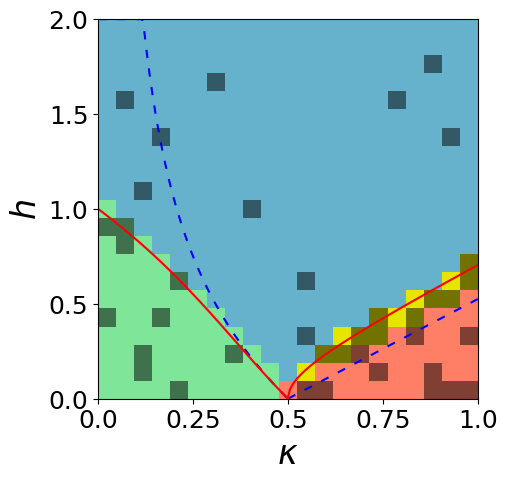

Generation: 0
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.12828: 100%|██████████| 1000/1000 [00:31<00:00, 31.46it/s]


[ 69  25   7 148  43  47  46   6 150 169 420 152 436  73 391 369 314 309
 322 193  83 102  58 104  12  10  18  57  17  33 100  78 122  77 124 167
  32  55 123 101]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


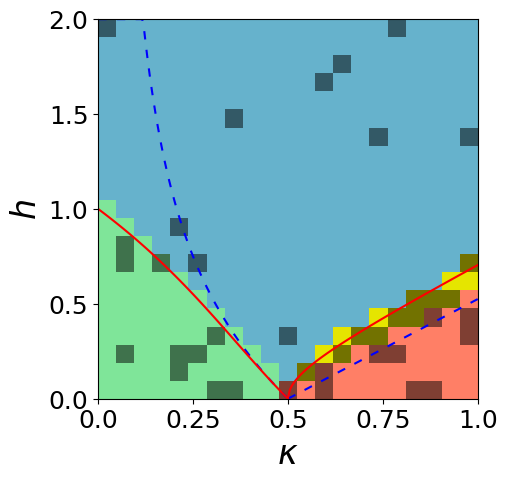

Generation: 1
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.11670: 100%|██████████| 1000/1000 [00:21<00:00, 45.74it/s]


[ 23  84 149  67  22   1 210   4   2 129 386 286 235 282 347 176 182 329
 408 288  37  58 102  12  81  41  60  14  17  59 100  99 101 146  78 145
 123 167 122  54]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


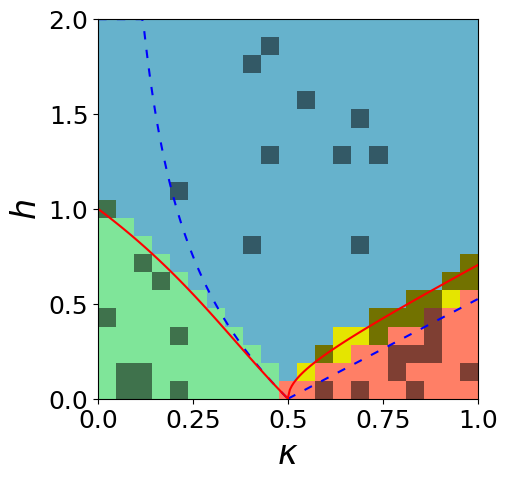

Generation: 2
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.11041: 100%|██████████| 1000/1000 [00:22<00:00, 45.14it/s]


[ 69  47 150   3 126  88 148   8  89  87 414 400 242 341 398 421 413 308
 237 378 104  62  79 102  39  40  36  57  34  17 100 146  55  76  78  99
 145 124  77 122]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


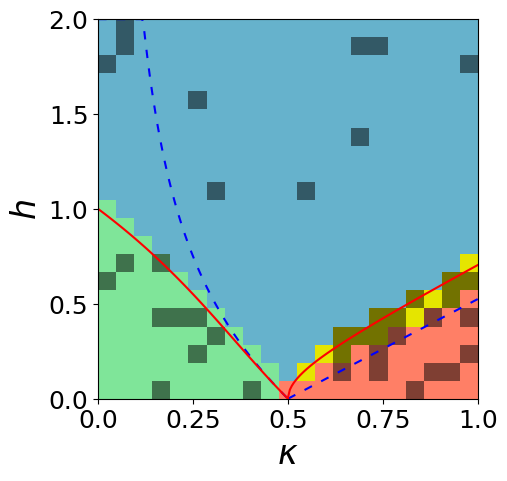

Generation: 3
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.11084: 100%|██████████| 1000/1000 [00:21<00:00, 45.46it/s]


[  5  46  66  90  88  85  50  21   6   2 281 438 405 219 428 340 230 351
 293 314  16 102  81  82 103  60  59  62  39  83  55 122  32  99  54  78
  76 101 145 124]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


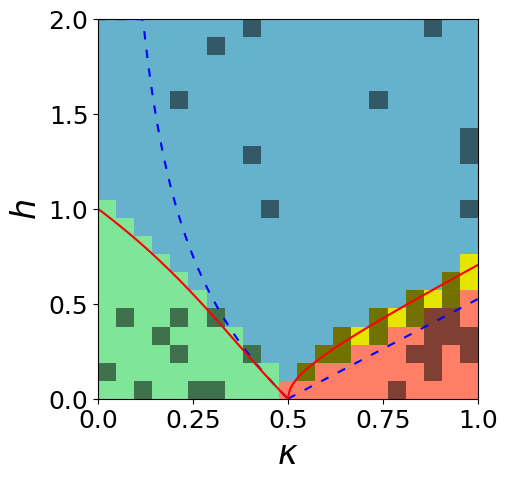

Generation: 4
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.10620: 100%|██████████| 1000/1000 [00:21<00:00, 45.47it/s]


[189 170  84  65   9 105 126   2 148 109 111 373 431 139 346 353 335 434
 162 208  18  62  15  19  14  34  60  11  56  10  78  77 146  55 124 101
  32 145 122  99]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


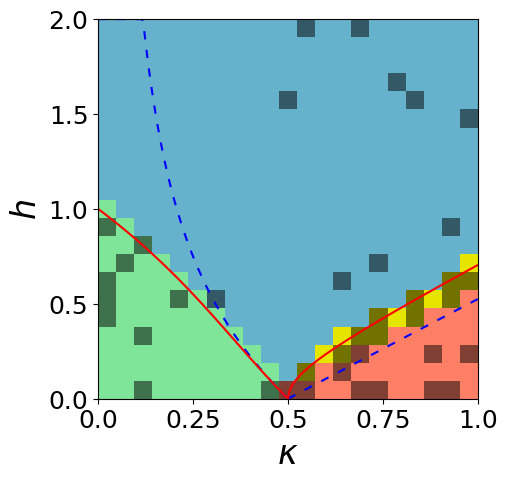

Generation: 5
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.11533: 100%|██████████| 1000/1000 [00:22<00:00, 44.90it/s]


[ 84  25 149 210   0  42  67  50  27  88 218 417 371 335 139 341 372 183
 340  96  19  57  41  17  83  61  80  62  13 104  54 123  99 145 101 100
 167 124  32  77]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


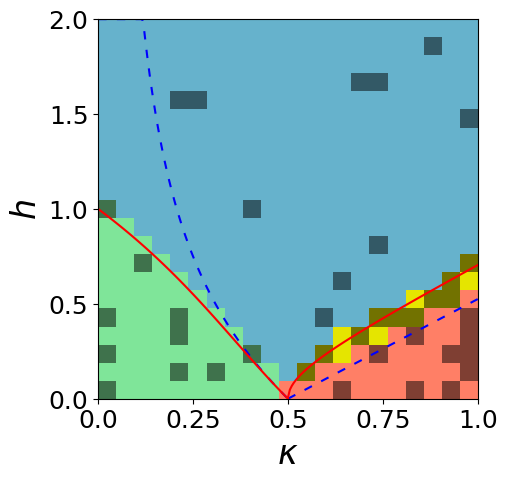

Generation: 6
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.10283: 100%|██████████| 1000/1000 [00:22<00:00, 44.76it/s]


[105  70 170  89 148  85  50  64 190   0 290 412 321 329 289 421 337 283
 226 136 102 103  39  14 125  59  15  60  41  11  99  54  55 100 167 122
 124 123  77  78]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


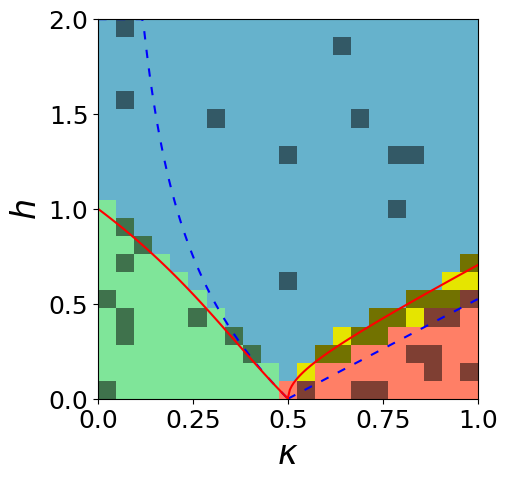

Generation: 7
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.10885: 100%|██████████| 1000/1000 [00:22<00:00, 45.11it/s]


[  3   8 189 128  85  23  42   1  65  64 279 284 248 302 225 388 384 400
 291 325  14 102 104  62  40  83  34  56  37  10 145 146 100 122  32  55
  76  77  54  78]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


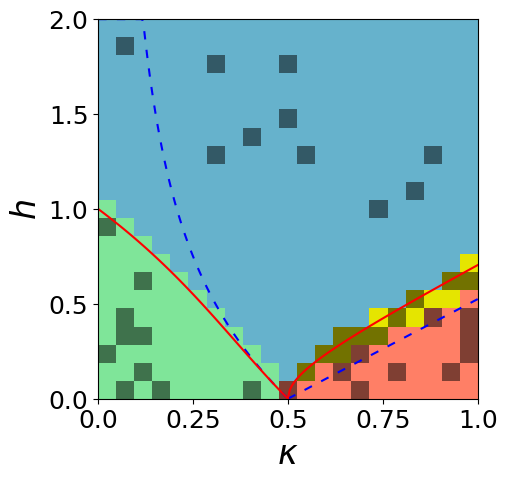

Generation: 8
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.10108: 100%|██████████| 1000/1000 [00:22<00:00, 45.21it/s]


[ 43  50  42 127  23  64  48  89 126  22 243 271 374 281 213 420 429 257
  73 412  62  17  15  38  61  40  80  10  59  12  78 122 123 101 124  32
  54 167  99  77]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


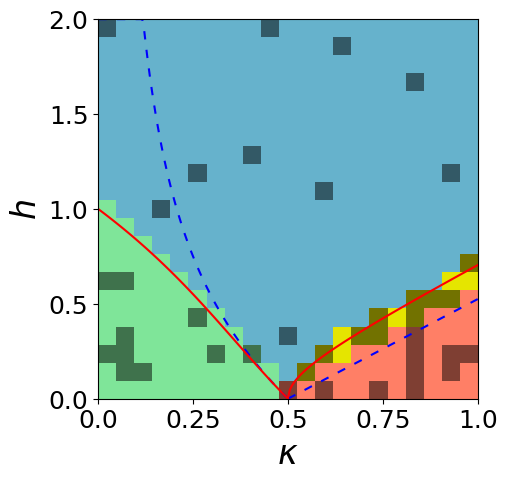

Generation: 9
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.09403: 100%|██████████| 1000/1000 [00:22<00:00, 44.82it/s]


[ 64 169  44  42 168   8 190 210  50   5 330 413 424 384 280 323 165 241
 204 422  14  15  18  57  81  20  19  34  60 102 146 123 122 101  78 100
 124  76  32  54]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


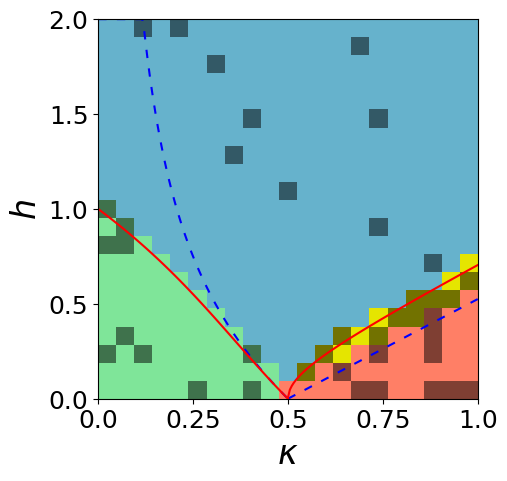

Generation: 10
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.10786: 100%|██████████| 1000/1000 [00:22<00:00, 44.42it/s]


[105 130 149  50  22 110  44   3 169 148 362 285 117 436 296 207 120 179
 412 335  10  18  20  14  39  37  59  36  60  58  76  55 123 124 100  32
 167 145  54  77]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


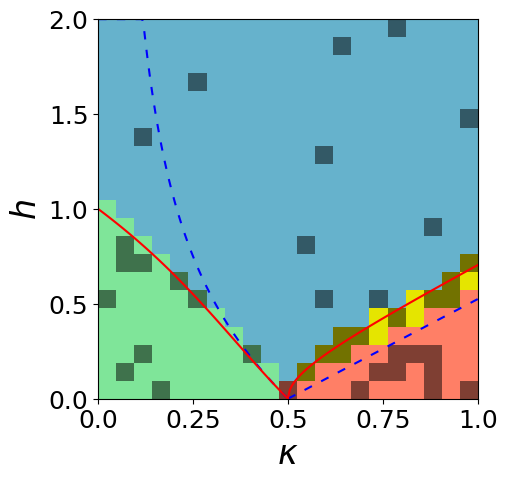

Generation: 11
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.11010: 100%|██████████| 1000/1000 [00:22<00:00, 45.01it/s]


[130  89   4  26  70  23 190   2  29 169 203 262 418 337 303 114 315 160
 391 406  82  13  33  36  62  39  37  80  83  81 100 167 145 122  32  77
  55 146 124 101]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


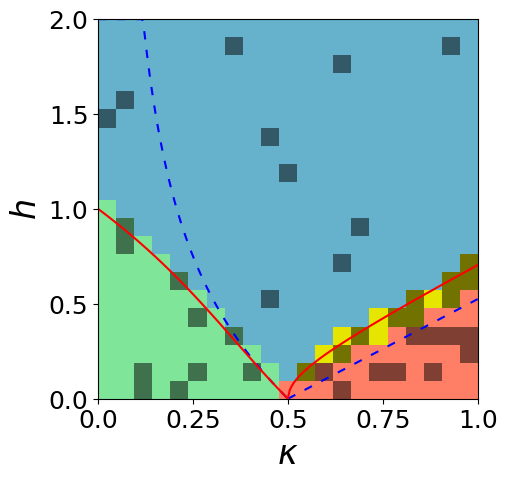

Generation: 12
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.10768: 100%|██████████| 1000/1000 [00:22<00:00, 44.98it/s]


[ 29 148  89 129  28  88   0  84 108 105 439 206 209 253 346 236 367  96
 342 328  37  59  15  34  57 102  10  60  61  56 145 146 101  32  76 100
 167  99  77 124]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


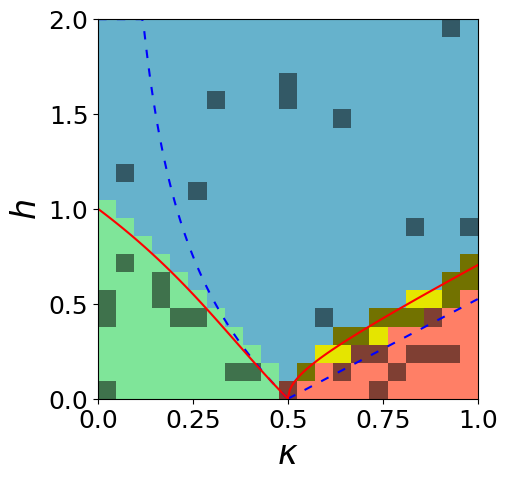

Generation: 13
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.10942: 100%|██████████| 1000/1000 [00:22<00:00, 44.87it/s]


[  7 108  90  85  30 107   6  48 128 189  72 286 201 223 119 376 140 316
 179 356  39  10  58  15  80  14  36  11  19  60  54 122 123  55 124 101
 145  78 146 167]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


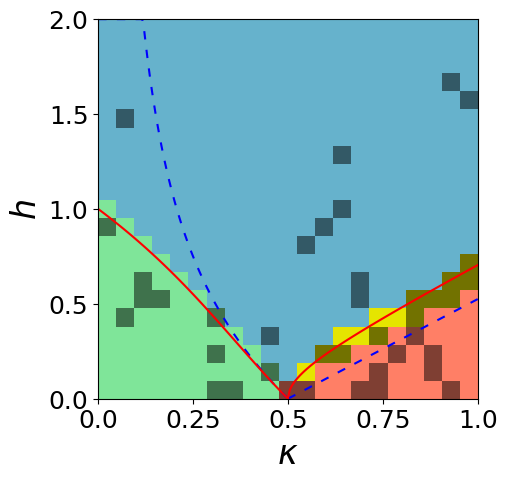

Generation: 14
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.11333: 100%|██████████| 1000/1000 [00:22<00:00, 44.43it/s]


[ 67 105  69  46  65   1  22 168 148 210 239 252 432 251 275 356 272 289
 133 231  37  33  34  16  61  83  79  62  60  38  32  77  55 124  78 100
  54 123 167 101]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


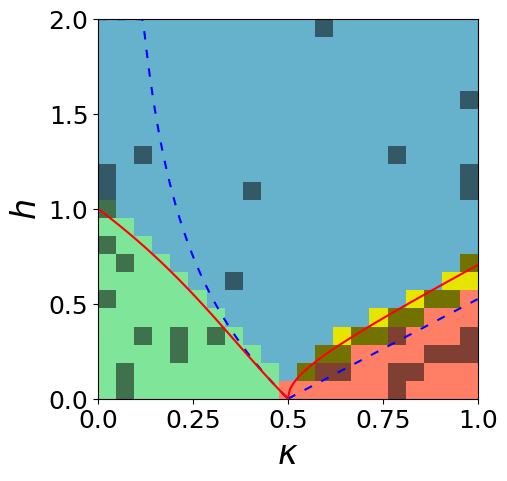

Generation: 15
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.11036: 100%|██████████| 1000/1000 [00:22<00:00, 44.62it/s]


[ 48 127  70   8  50  30  68  43   5  49  92 332 288 116 139 183 418 114
 242 428  36  60  11  38  39  12 125  16  15  35 124 167 145 146  77 101
  99  54  55  32]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


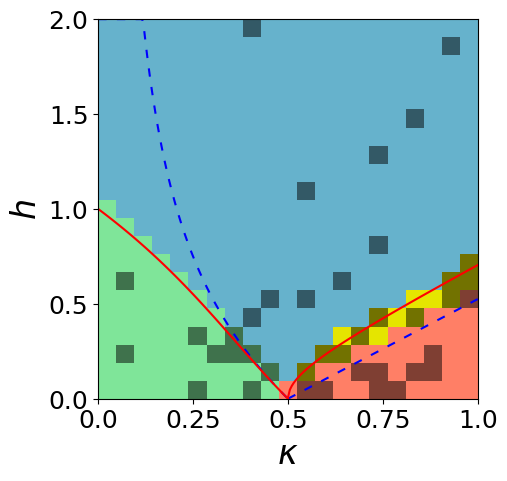

Generation: 16
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.09662: 100%|██████████| 1000/1000 [00:22<00:00, 44.89it/s]


[  8  66   0   1  69   9  25 210  70 110 157 198 262 431 401 230 304 306
 156 350  61  15  13  33  80  11  60  59  35  20  32 100 167 122  78  55
 146  76 145 101]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


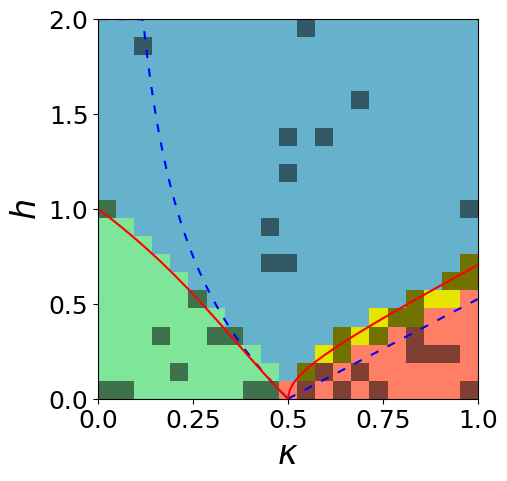

Generation: 17
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.10222: 100%|██████████| 1000/1000 [00:22<00:00, 44.92it/s]


[ 90  84  27 130 147  30  21  23 105 127 222 118 319 377 396 159 188 121
  75 256  82  18  58  56  60  17 104  13  14  33  76  54  99  32  77  78
 124 101  55 145]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


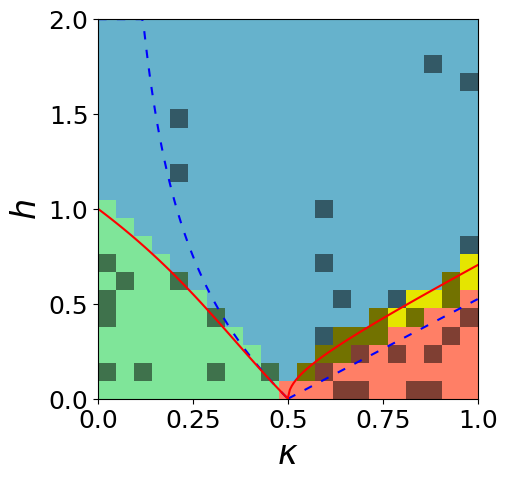

Generation: 18
Labels: [0 1 2 3]
Number of training points: 40


Loss: 0.11458: 100%|██████████| 1000/1000 [00:22<00:00, 44.40it/s]


[147  67  47  85 107  23 149  69  45   1 391 236 352 115 139 433 360 409
 303  93  12  20  33  62  17  79  19  81  36 103 122 145  99  55 100 124
  78  32 123  77]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


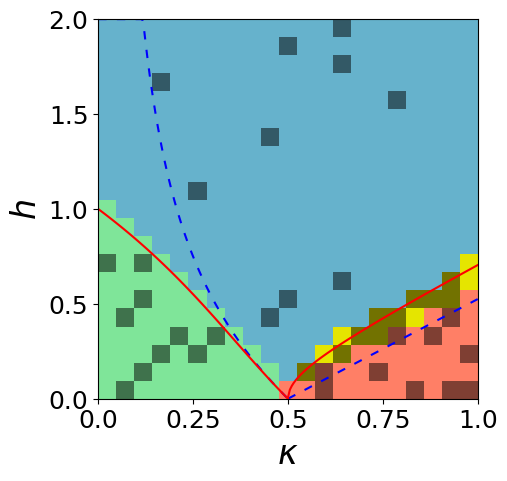

Generation: 19
Labels: [0 1 2 3]
Number of training points: 40


Generation: 19/20: 100%|██████████| 20/20 [07:39<00:00, 22.99s/it]


In [63]:
TT.train_rotate(True, False, 10, 1000, 20)

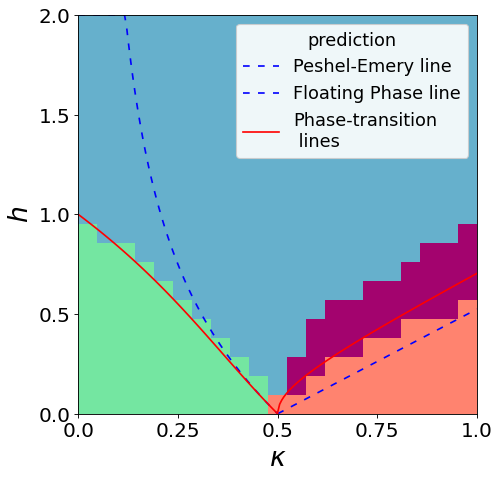

In [64]:
TT.predict(plot=True)

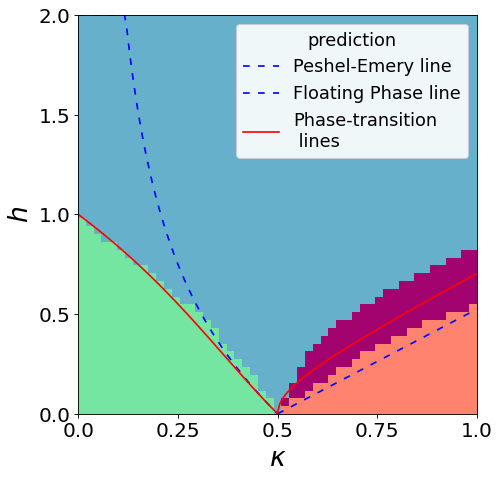

In [61]:
TT.predict(plot=True)

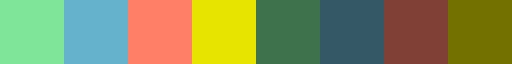

In [86]:
col8 = [[0.5, 0.9, 0.6, 1],
        [0.4, 0.7, 0.8, 1],
        [1.0, 0.5, 0.4, 1],
        [0.9, 0.9, 0.0, 1],
        [0.5/2, 0.9/2, 0.6/2, 1],
        [0.4/2, 0.7/2, 0.8/2, 1],
        [1.0/2, 0.5/2, 0.4/2, 1],
        [0.9/2, 0.9/2, 0.0/2, 1]]
# Relative colormaps
cm8 = ListedColormap(col8, name='color8')
cm8

In [4]:
TT.qcnn.reset_params()
TT.train(epochs=500, train_indices=X, labels4=True)

Labels: [0 1 2 3]
Number of training points: 40


  0%|          | 0/500 [00:00<?, ?it/s]/home/saverio/.local/lib/python3.10/site-packages/autoray/autoray.py:981: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)
Loss: 0.13454: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s]


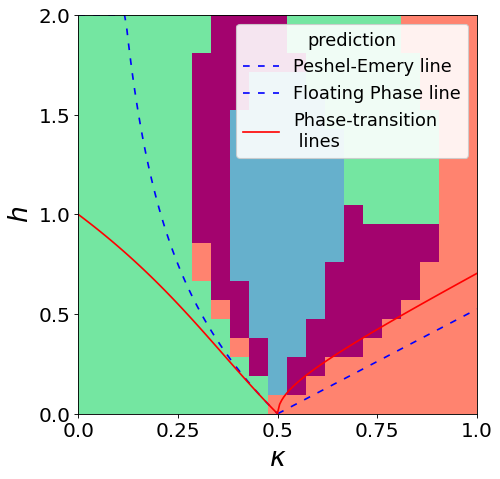

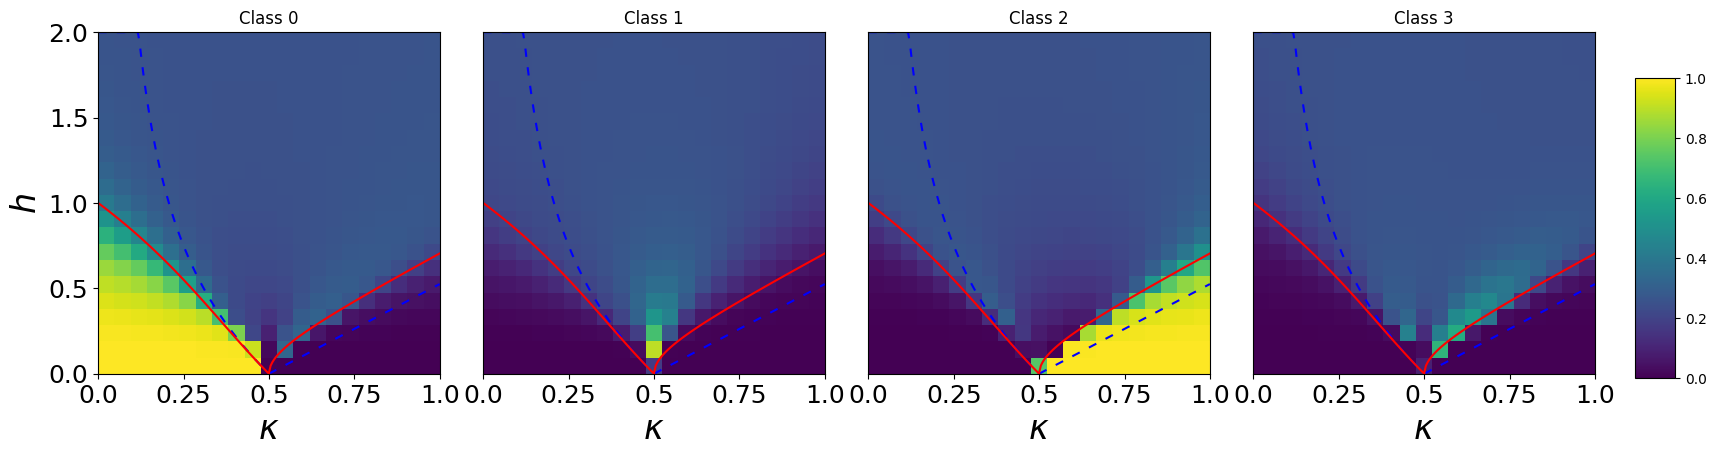

In [23]:
TT.predict(plot=True, eachclass = True)

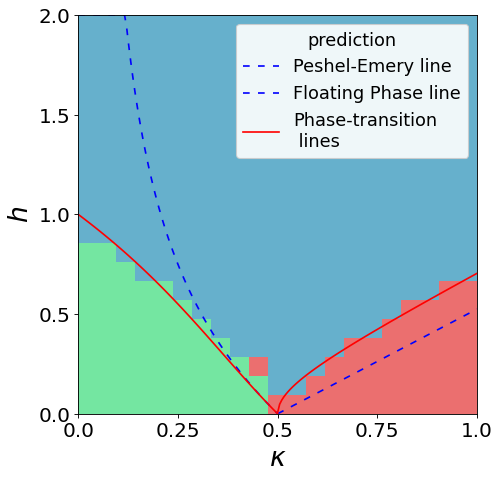

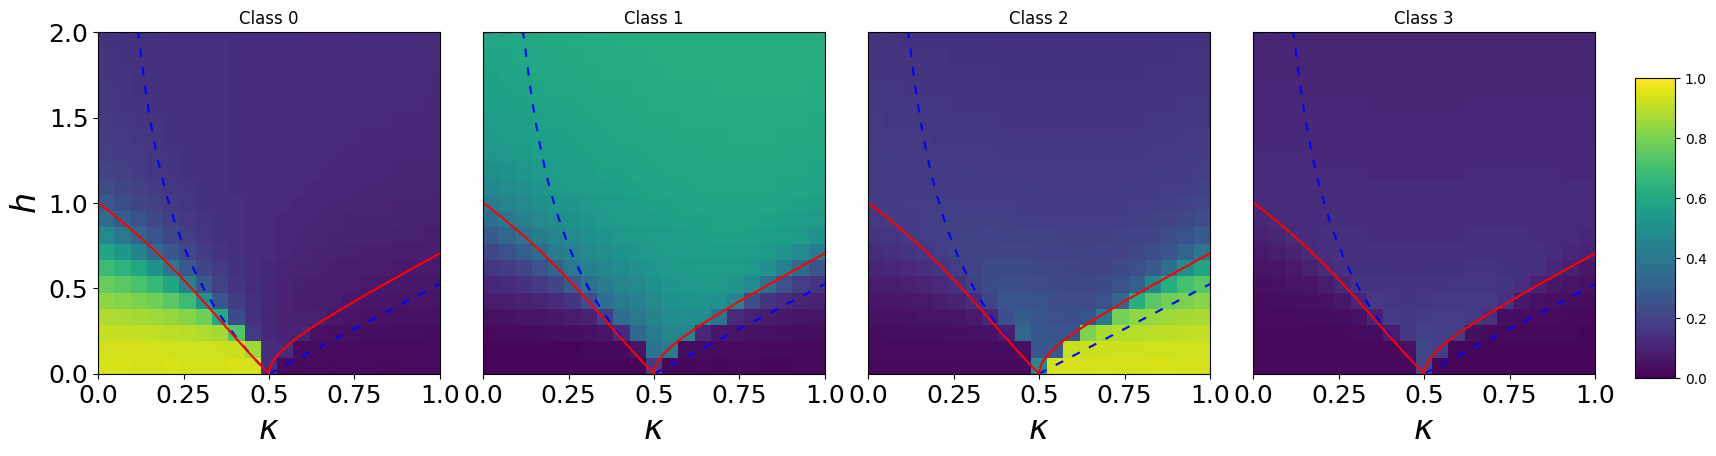

In [4]:
TT.predict(plot=True, eachclass=True)

## Training only using one of the three Phases:

In [5]:
import matplotlib.pyplot as plt
import numpy as np

20
Labels: [0]
Number of training points: 20


Loss: 0.02639: 100%|██████████| 250/250 [00:14<00:00, 17.18it/s]


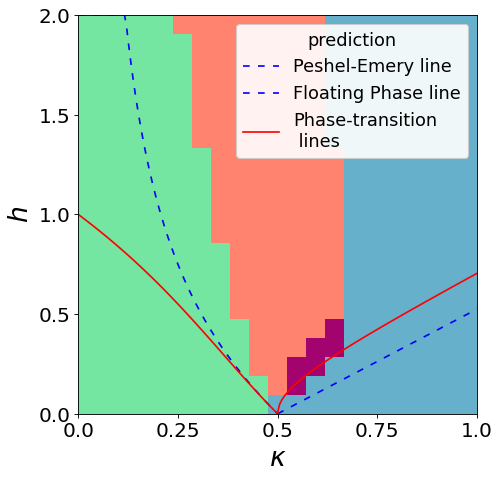

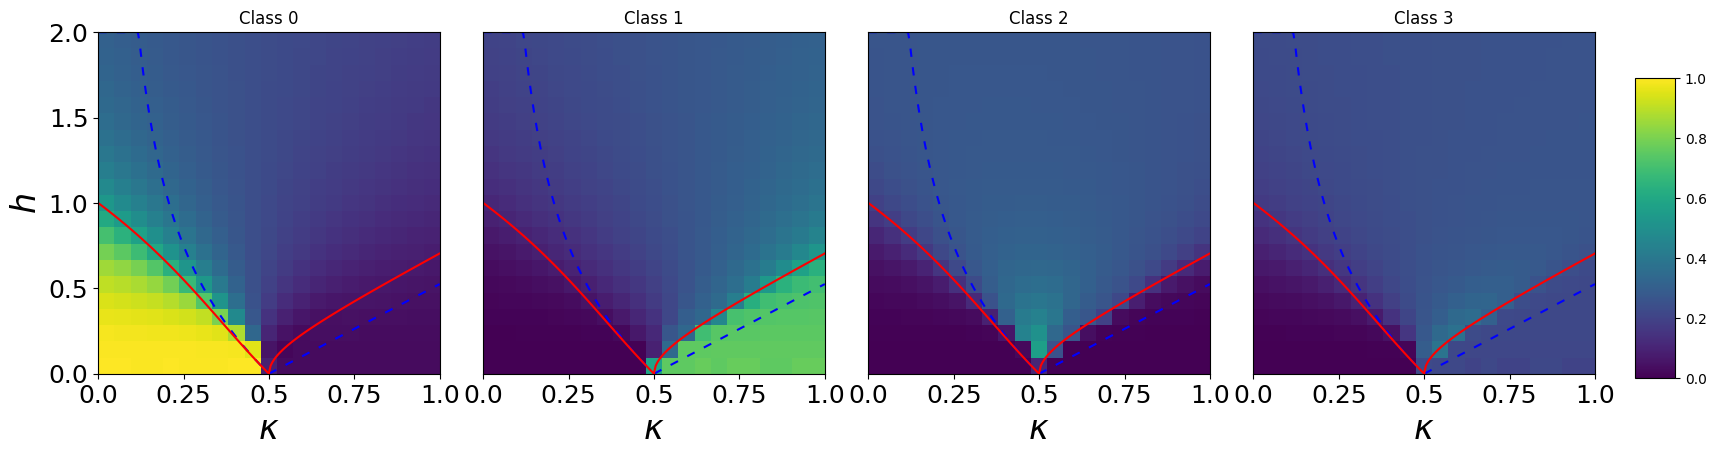

10
Labels: [1]
Number of training points: 10


Loss: 0.00988: 100%|██████████| 250/250 [00:11<00:00, 22.05it/s] 


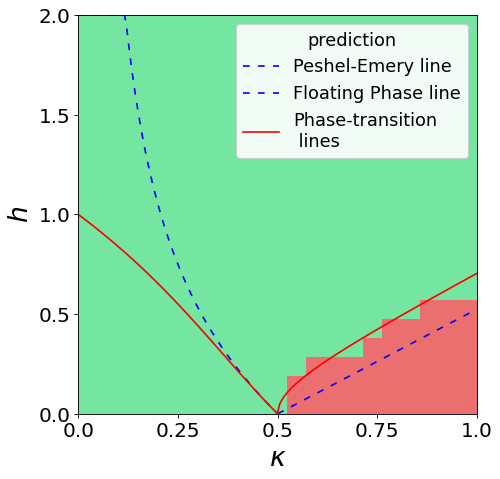

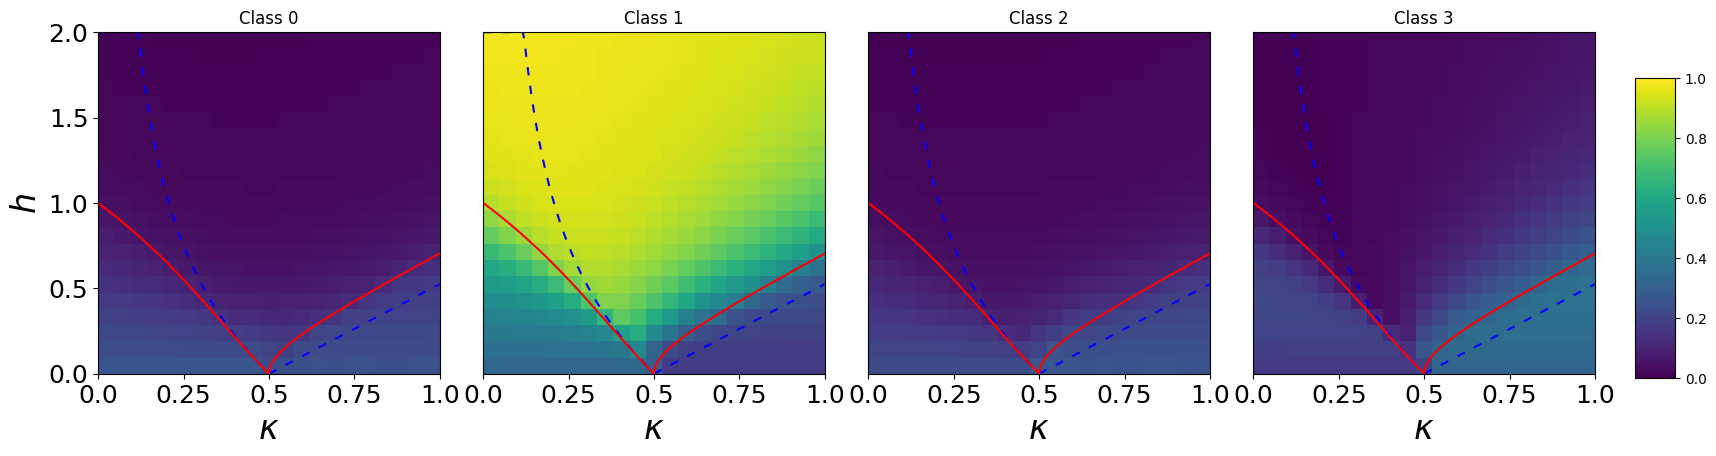

11
Labels: [2]
Number of training points: 11


Loss: 0.01251: 100%|██████████| 250/250 [00:11<00:00, 21.83it/s] 


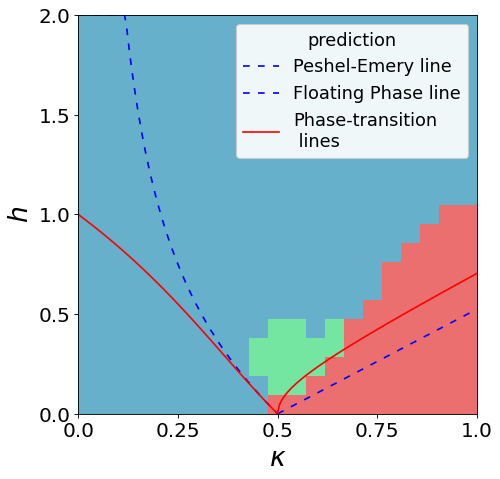

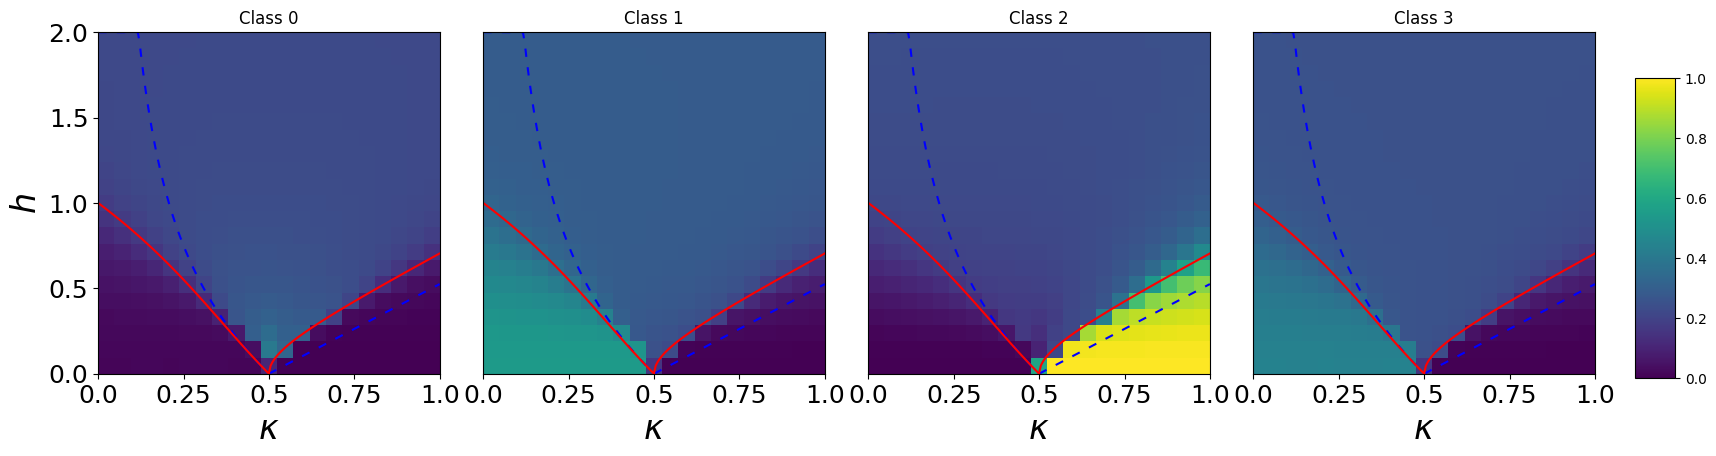

In [6]:
masks = [TT.mask_analitical_ferro, TT.mask_analitical_para, TT.mask_analitical_anti]

for mask in masks:
    print(sum(mask))
    TT.qcnn.reset_params()
    TT.train(epochs=250, train_indices=mask)
    TT.predict(plot=True, eachclass = True)
    plt.show()

## Training only using two of the three Phases:

Labels: [0 1]
Number of training points: 30


Loss: 0.05611: 100%|██████████| 250/250 [00:18<00:00, 13.34it/s]


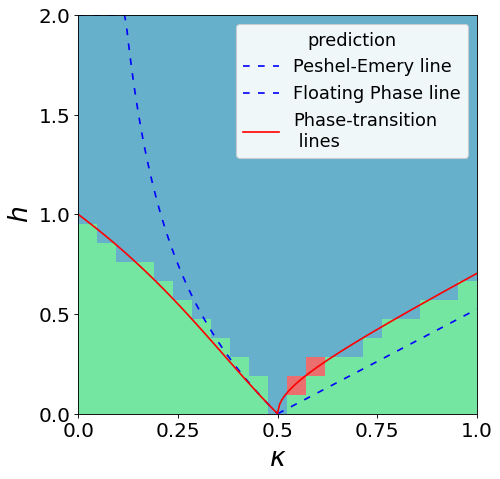

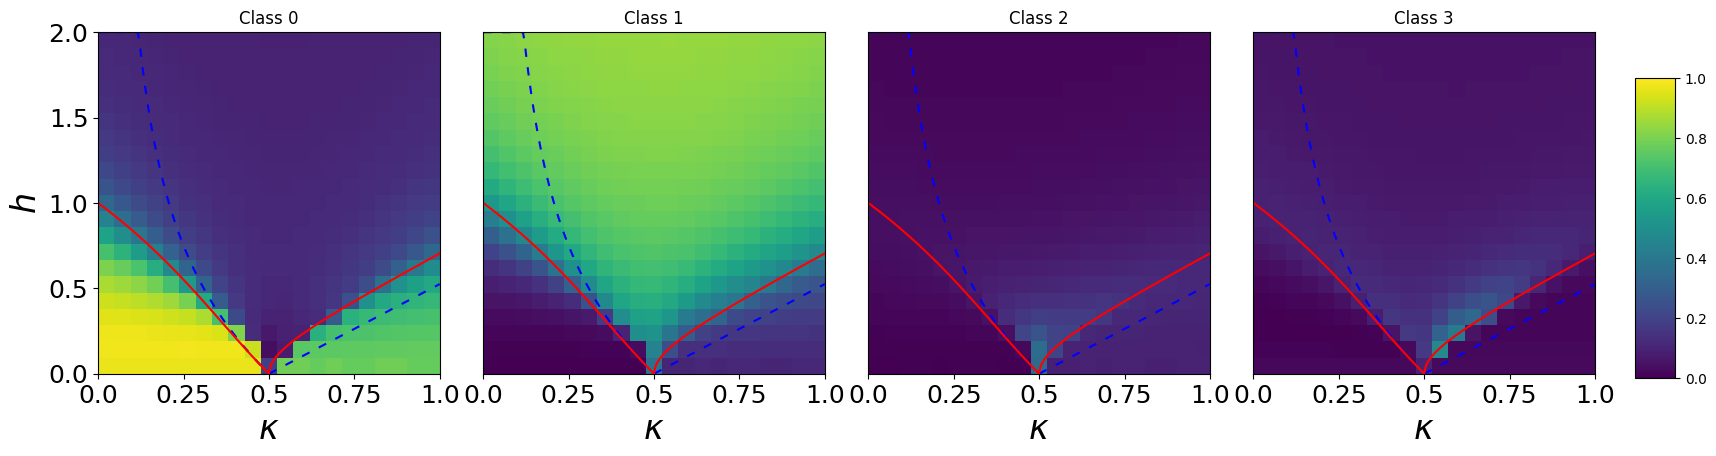

Labels: [0 2]
Number of training points: 31


Loss: 0.01869: 100%|██████████| 250/250 [00:19<00:00, 12.89it/s]


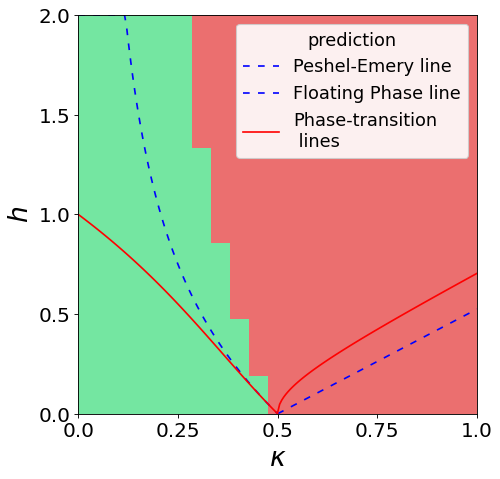

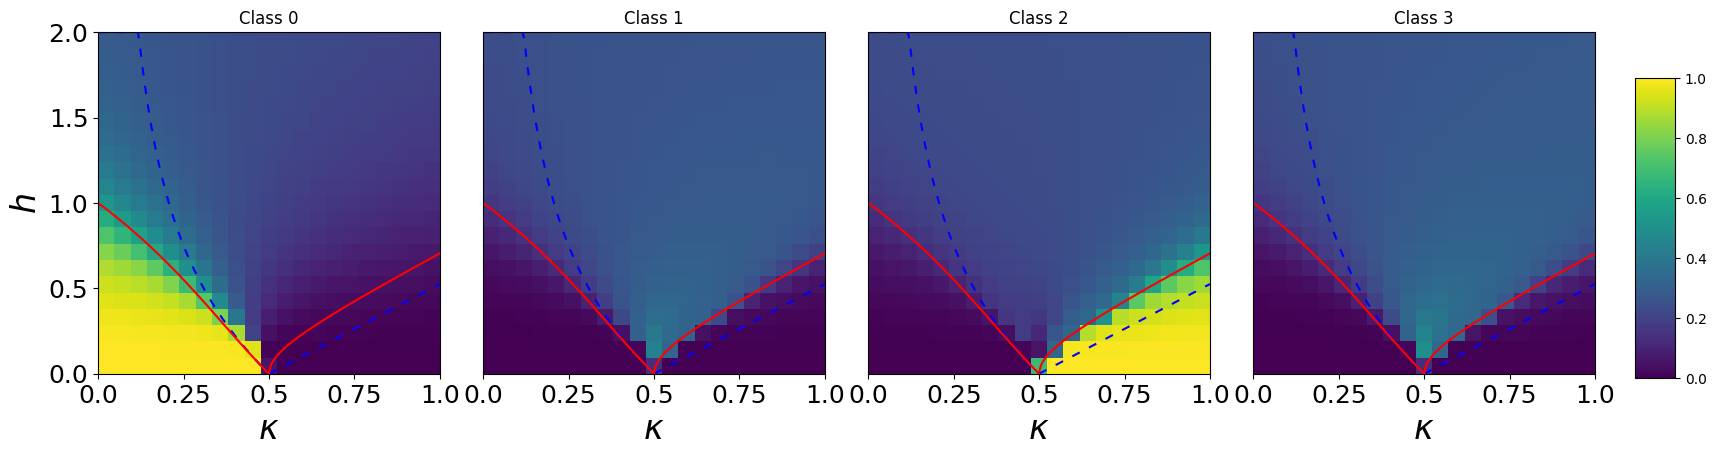

Labels: [1 2]
Number of training points: 21


Loss: 0.02760: 100%|██████████| 250/250 [00:15<00:00, 16.10it/s]


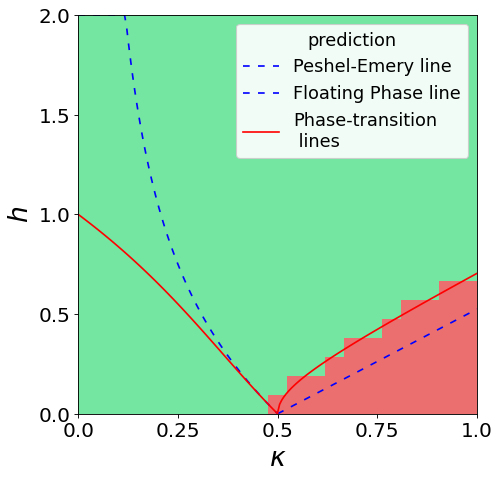

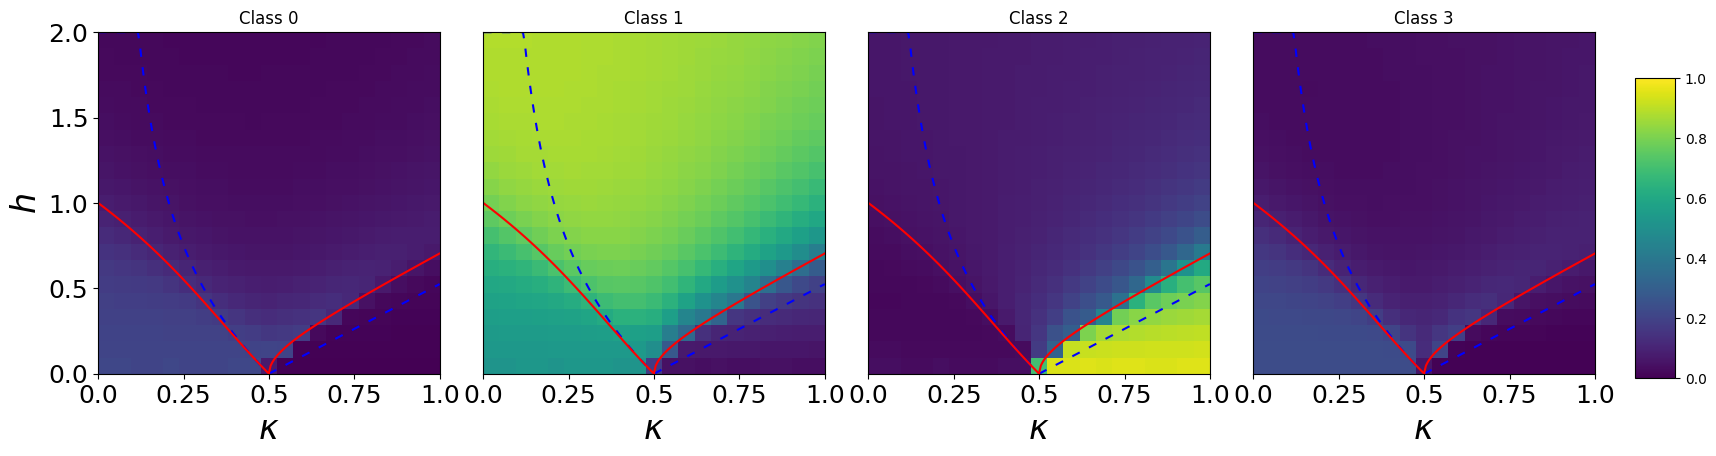

In [7]:
masks2 = [np.logical_or(masks[0], masks[1]), np.logical_or(masks[0], masks[2]), np.logical_or(masks[1], masks[2])]

for mask in masks2:
    TT.qcnn.reset_params()
    TT.train(epochs=250, train_indices=mask)
    TT.predict(plot=True, eachclass = True)
    plt.show()

In [6]:
import numpy as np

In [10]:
TT.labels4

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [12]:
TT.mask_analitical

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,

In [14]:
np.array([True]*len(TT.labels4))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

Labels: [0 1 2 3]
Number of training points: 441


  0%|          | 0/500 [00:00<?, ?it/s]/home/saverio/.local/lib/python3.10/site-packages/autoray/autoray.py:981: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)
Loss: 0.10376: 100%|██████████| 500/500 [02:43<00:00,  3.05it/s]


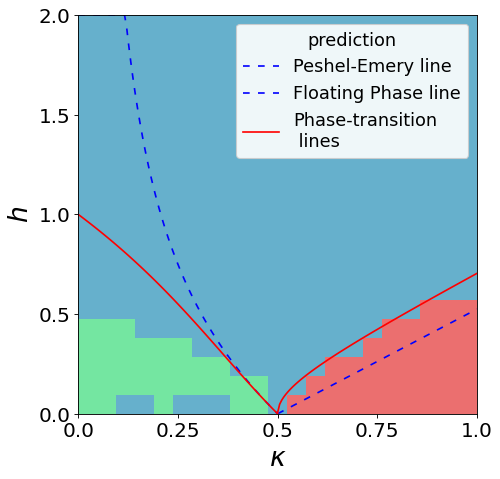

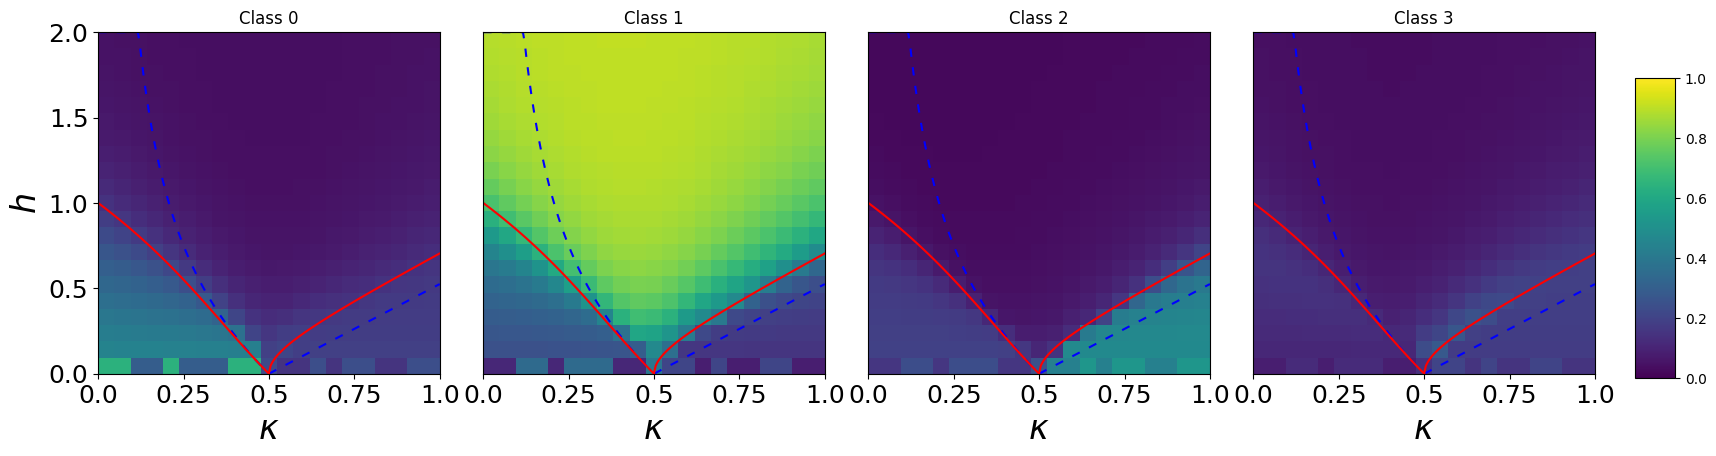

In [17]:
TT = ANNNI.mps(gpu=True)
TT.train(epochs=500, train_indices=np.array([True]*len(TT.labels4)), labels4=True)
TT.predict(plot=True, eachclass = True)

In [32]:
mask34 = np.logical_or(TT.labels4 == 3, TT.labels4 == 2)

Labels: [2 3]
Number of training points: 51


  0%|          | 0/500 [00:00<?, ?it/s]/home/saverio/.local/lib/python3.10/site-packages/autoray/autoray.py:981: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)
Loss: 0.09235: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s]


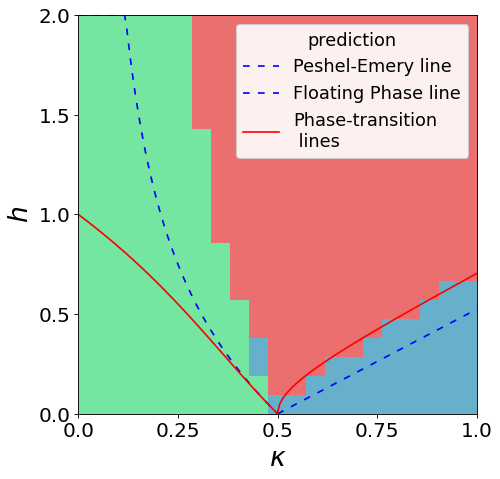

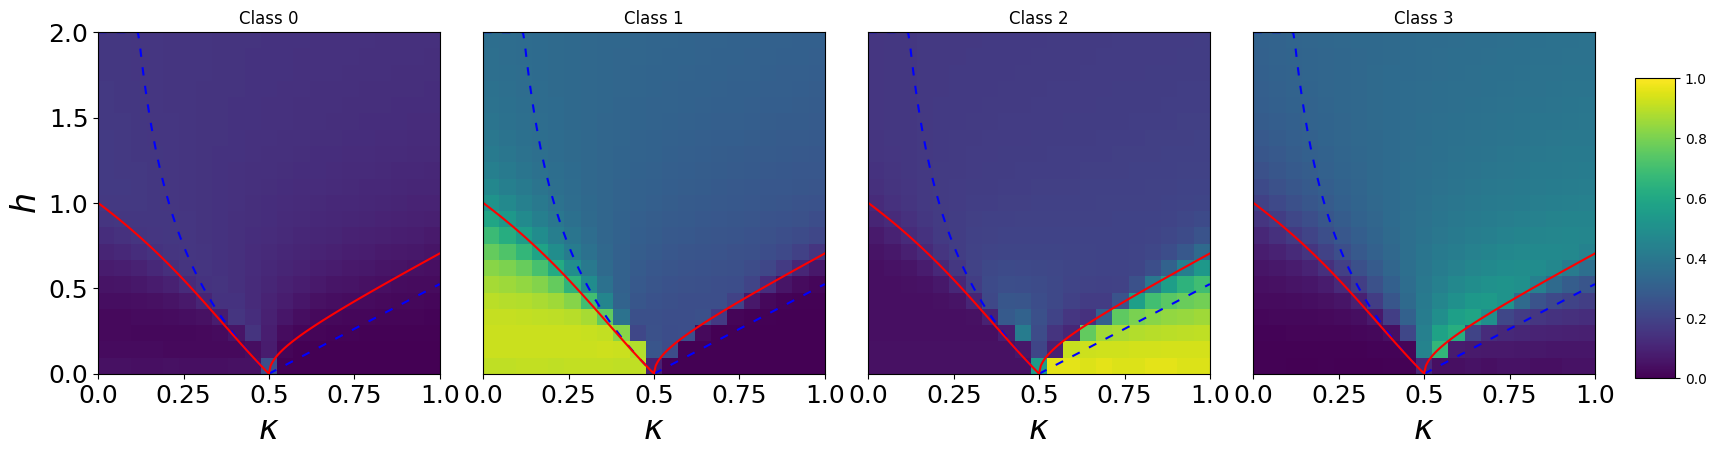

In [34]:
TT = ANNNI.mps(gpu=True)
TT.train(epochs=500, train_indices=mask34, labels4=True)
TT.predict(plot=True, eachclass = True)